# Đồ án 3 - Fake News Detection

## Bảng phân công

|Họ và tên|MSSV|Công việc|
| :------ | :---: | :--------- |
|Võ Thành Nam|19120301|Mô hình Decision Tree|
|Lương Ánh Nguyệt|19120315|Mô hình Multinomial Naive Bayes, deploy website|
|Phạm Lưu Mỹ Phúc|19120331|EDA, thiết kế website|
|Bùi Quang Bảo|19120454|Tiền xử lý dữ liệu, mô hình MLP Classifier|

## Website deploy

https://share.streamlit.io/nnguyet/fake-news-detection/app.py

## Thư viện

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns
import warnings

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
set_config(display='diagram')

In [2]:
# pyvi: https://pypi.org/project/pyvi/0.0.7.5/ - Vietnamese tokenizing tool
# !pip install pyvi
from pyvi import ViTokenizer, ViPosTagger
# !pip install dill
import dill 
# !pip install wordcloud
import wordcloud 

## Dữ liệu

Nguồn dữ liệu: VNFD Dataset - [vn_news_223_tdlfr.csv](https://github.com/thanhhocse96/vfnd-vietnamese-fake-news-datasets/blob/master/CSV/vn_news_223_tdlfr.csv)

Mô tả dữ liệu: [Mô tả tập VNFD](https://github.com/thanhhocse96/vfnd-vietnamese-fake-news-datasets/tree/master/CSV)

In [3]:
df = pd.read_csv("data/vn_news_223_tdlfr.csv")
df = df.drop(columns=['domain'])
df

,text,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\r...,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",1
...,...,...
218,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,0
219,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,0
220,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,0
221,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,0


Chúng ta sẽ chia dữ liệu thành 2 tập train và validation, với tỉ lệ 80/20.

Từ giờ, mọi bước liên quan đến tiền xử lý, trích xuất đặc trưng, train mô hình học máy đều chỉ thực hiện trên tập train. Tập validation sẽ được để dành cho việc kiểm tra lại mô hình.

In [4]:
X_df = df.drop("label", axis=1)
Y_sr = df["label"]

train_X_df, val_X_df, train_Y_sr, val_Y_sr = train_test_split(
    X_df, Y_sr, 
    test_size = 0.2, 
    stratify = Y_sr, 
    random_state = 42
)

## Tiền xử lý văn bản tiếng Việt

Stopwords: https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt

Tokenizer: Pyvi - Vietnamese tokenizing tool - https://pypi.org/project/pyvi/0.0.7.5/


Quá trình xử lý 1 đoạn text được thực hiện như sau:

* Tokenize
* Remove punctuations
* Remove special chars
* Remove links
* Lowercase
* Remove stopwords

In [5]:
with open("stopwords/vietnamese-stopwords.txt",encoding='utf-8') as file:
    stopwords = file.readlines()
    stopwords = [word.rstrip() for word in stopwords]

punctuations = '''!()-–=[]{}“”‘’;:'"|\,<>./?@#$%^&*_~'''

special_chars = ['\n', '\t']

regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' # domain
        r'localhost|' # localhost
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ip
        r'(?::\d+)?' # port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)   

In [6]:
def tokenize(text):
    tokenized_text = ViPosTagger.postagging(ViTokenizer.tokenize(text))
    return tokenized_text[0]

def is_punctuation(token):
    global punctuations
    return True if token in punctuations else False

def is_special_chars(token):
    global special_chars
    return True if token in special_chars else False

def is_link(token):
    return re.match(regex, token) is not None

def lowercase(token):
    return token.lower()

def is_stopword(token):
    global stopwords
    return True if token in stopwords else False

# ===============================================================
# Process:
# Text -> Tokenize (pyvi) -> Remove punctuations -> Remove special chars 
# -> Remove links -> Lowercase -> Remove stopwords -> Final Tokens
# ===============================================================
def vietnamese_text_preprocessing(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if not is_punctuation(token)]
    tokens = [token for token in tokens if not is_special_chars(token)]
    tokens = [token for token in tokens if not is_link(token)]
    tokens = [lowercase(token) for token in tokens]
    tokens = [token for token in tokens if not is_stopword(token)]
    # return tokens
    return tokens

Ví dụ sử dụng:

In [7]:
# Trích 1 đoạn từ https://www.fit.hcmus.edu.vn/
demo_text = 'Trải qua hơn 25 năm hoạt động, Khoa Công nghệ Thông tin (CNTT) đã phát triển vững chắc và được Chính phủ bảo trợ để trở thành một trong những khoa CNTT đầu ngành trong hệ thống giáo dục đại học của Việt Nam.'

demo_text_to_tokens = vietnamese_text_preprocessing(demo_text)
print(demo_text_to_tokens)

['trải', '25', 'hoạt_động', 'khoa', 'công_nghệ', 'thông_tin', 'cntt', 'phát_triển', 'vững_chắc', 'chính_phủ', 'bảo_trợ', 'trở_thành', 'khoa', 'cntt', 'đầu', 'ngành', 'hệ_thống', 'giáo_dục', 'đại_học', 'việt_nam']


# EDA

In [8]:
print("Shape: ",df.shape)
print("Columns: ", df.columns.tolist())

Shape:  (223, 2)
Columns:  ['text', 'label']


Dữ liệu có 223 dòng với 2 cột là `text` chứa nội dung bản record Tiếng Việt và `label` chứa nhãn (1: tin giả, 0: tin thật)

## Kiểm tra dữ liệu bị thiếu, sai kiểu dữ liệu (nếu có)

In [9]:
df.dtypes

text     object
label     int64
dtype: object

In [10]:
df.isna().sum()

text     0
label    0
dtype: int64

Dữ liệu không bị thiếu hay sai kiểu dữ liệu. 

## Kiểm tra phân bố các class có chênh lệch không

In [11]:
df.label.value_counts()

0    123
1    100
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

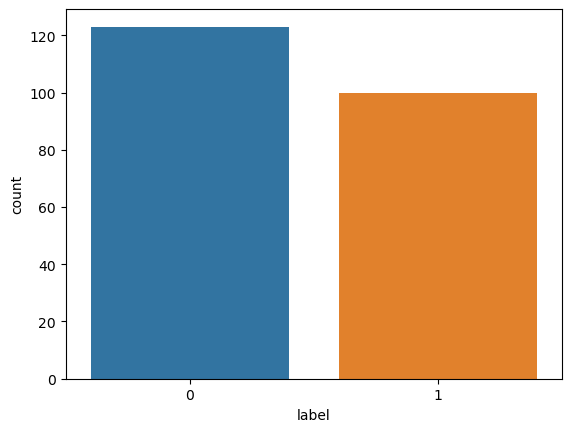

In [12]:
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.countplot(df.label)

# Các thông tin thống kê của văn bản (chiều dài trung bình mỗi record, v.v)

In [13]:
len_text = df['text'].apply(lambda x: len(x.split()))
len_text.describe()

count     223.000000
mean      564.713004
std       400.137418
min        69.000000
25%       289.000000
50%       450.000000
75%       733.000000
max      2331.000000
Name: text, dtype: float64

Chiều dài trung bình mỗi record là 564.713 

Trong đó, record ngắn nhất có 69 từ, record dài nhất có 2331 từ 

### Trực quan hóa các từ hay xuất hiện trong Fake news và Real news

In [14]:
fake_news_df = df[df['label'] == 1]
real_news_df = df[df['label'] == 0]

In [15]:
def visulize_frequency_word(df, title):
    words_df = []
    df['text'].apply(lambda x: words_df.extend(vietnamese_text_preprocessing(x)))
    wordcloud = WordCloud(background_color="white").generate(' '.join(words_df))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

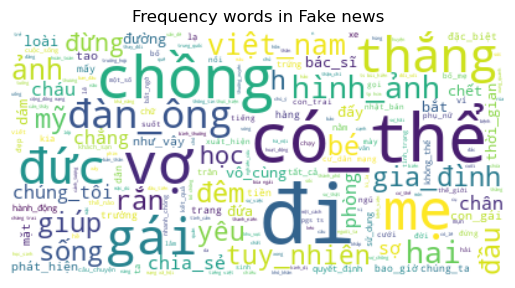

In [16]:
visulize_frequency_word(fake_news_df, "Frequency words in Fake news")


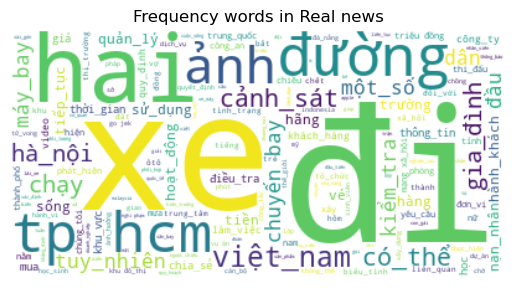

In [17]:
visulize_frequency_word(real_news_df, "Frequency words in Real news")

## Xây dựng mô hình máy học: MLPClassifier

#### Xây dựng pipeline

Pipeline: 
* **PreprocessAndFeaturesExtract**: Tiền xử lý văn bản và trích xuất đặc trưng
  * **Tiền xử lý văn bản**: Đã được cài đặt ở phần trên (hàm `vietnamese_text_preprocessing`)
  * **Trích xuất đặc trưng**: Văn bản -> Ma trận đặc trưng TF-IDF (`sklearn.feature_extraction.text.TfidfVectorizer` - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* **Mô hình phân lớp mạng neural MLPClassifier** (`sklearn.neural_network.MLPClassifier` - https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [18]:
class PreprocessAndFeaturesExtract(BaseEstimator, TransformerMixin):
    def __init__(self):
        # print("> PreprocessAndFeaturesExtract > INIT")
        self.trained_tokens = []

    # ===============================================================
    # Mỗi lần train chỉ gọi 1 lần fit
    # Mỗi lần fit thì sẽ tạo 1 list trained_tokens, bao gồm những tokens/đặc trưng đã được train
    # ===============================================================
    def fit(self, X_df, y=None):

        # Return a list of preprocessed_texts
        preprocessed_texts = []
        for index, row in X_df.iterrows():
            tokens = vietnamese_text_preprocessing(row['text'])
            preprocessed_texts.append(' '.join(tokens))
        preprocessed_texts = np.array(preprocessed_texts)

        # preprocessed_texts -> features
        tv = TfidfVectorizer(min_df = 0.0, max_df = 1.0, use_idf = True)
        tv_matrix = tv.fit_transform(preprocessed_texts)
        tv_matrix = tv_matrix.toarray()
#         df_features = pd.DataFrame(np.round(tv_matrix, 2), columns = tv.get_feature_names_out())
        df_features = pd.DataFrame(np.round(tv_matrix, 2), columns = tv.get_feature_names())

        self.trained_tokens = df_features.columns.values

        # print(f"> PreprocessAndFeaturesExtract > FIT > X_df: {X_df.shape} > df_features: {df_features.shape}")
        # print(f"self.trained_tokens: {self.trained_tokens}")

        return self

    # ===============================================================
    # Khá giống phương thức fit (ở bước tiền xử lý, và trích xuất đặc trưng), tuy nhiên:
    # fit:       Gọi 1 lần duy nhất mỗi lần train
    # transform: Được gọi nhiều lần, và có thể áp dụng với nhiều X_df khác nhau (để tính score hay predict chẳng hạn),
    #            dựa trên cái model đã được train trước đó bằng fit
    # ===============================================================
    # fit tạo mới self.trained_tokens, transform thì không
    # ===============================================================
    # transform được cài đặt để trả về những đặc trưng ĐÃ được học,
    # những đặc trưng chưa học thì sẽ bỏ qua
    # ===============================================================
    def transform(self, X_df, y=None):

        # Return a list of preprocessed_texts
        preprocessed_texts = []
        for index, row in X_df.iterrows():
            tokens = vietnamese_text_preprocessing(row['text'])
            preprocessed_texts.append(' '.join(tokens))
        preprocessed_texts = np.array(preprocessed_texts)

        # Features Extraction
        # preprocessed_texts -> features
        # TF-IDF Model
        tv = TfidfVectorizer(min_df = 0.0, max_df = 1.0, use_idf = True)
        tv_matrix = tv.fit_transform(preprocessed_texts)
        tv_matrix = tv_matrix.toarray()
#         vocab = tv.get_feature_names_out()
        vocab = tv.get_feature_names()
        temp_df_features = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
        n_rows = temp_df_features.shape[0]
        df_features = pd.DataFrame()

        for trained_token in self.trained_tokens:
            if trained_token in vocab:
                df_features[trained_token] = temp_df_features[trained_token]
            else:
                df_features[trained_token] = [0.000]*n_rows

        # print(f"\n> PreprocessAndFeaturesExtract > TRANSFORM > X_df: {X_df.shape} > df_features: {df_features.shape}")

        return df_features

# Predict function
# Input: A string
# Output: Label (0 - non fake news, 1 - fake news)
def mlp_predict(text):
    mlp_pd = pd.DataFrame()
    mlp_pd["text"] = [text]
    pred_result = pipeline_mlp.predict(mlp_pd)[0]
    return pred_result

In [19]:
# MLPClassifier
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(50),
    activation='relu',
    solver='lbfgs',
    random_state=0,
    max_iter=10000
)

# Pipeline: PreprocessAndFeaturesExtract -> MLPClassifier
pipeline_mlp = Pipeline(
    steps=[
           ("vnpreprocess", PreprocessAndFeaturesExtract()),
           ("mlpclassifier", mlp_classifier)
           ]
)
pipeline_mlp

Pipeline(steps=[('vnpreprocess', PreprocessAndFeaturesExtract()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=50, max_iter=10000,
                               random_state=0, solver='lbfgs'))])

#### Train

Tiến hành huấn luyện mô hình trên tập train

In [20]:
pipeline_mlp.fit(train_X_df, train_Y_sr)
print("> Train completed")

> Train completed


#### Score

Tính accuracy của mô hình, sử dụng lần lượt tập train và tập validation.

In [21]:
train_acc = pipeline_mlp.score(train_X_df, train_Y_sr)
print(f"Train Accuracy = {train_acc}")

val_acc = pipeline_mlp.score(val_X_df, val_Y_sr)
print(f"Validation Accuracy = {val_acc}")

Train Accuracy = 1.0
Validation Accuracy = 0.8444444444444444


#### Predict (Demo)

Dự đoán label của văn bản mới, với label: 
* 0 - non fake news
* 1 - fake news

Ở đây chúng ta sẽ demo 2 đoạn văn bản được lấy ngẫu nhiên từ 2 bài báo của 2 trang web là kenh14.vn và thanhnien.vn. 

Việc chọn 2 bài báo hoàn toàn ngẫu nhiên và không có chủ đích muốn nói rằng trang nào chứa fake news hay không. Kết quả mọi output đều chỉ là dự đoán.

In [22]:
# Trích 1 đoạn từ: https://kenh14.vn/star/fan-nhao-nhao-vi-tin-cuc-hot-cu-kim-soo-hyun-se-co-fan-meeting-tai-viet-nam-20140402111911750.chn
demo_text_1 = 'Vào đúng dịp Cá tháng tư (01/4), trang fanpage của Kim Soo Hyun Việt Nam bất ngờ đăng tải thông tin cho biết chàng "Cụ" 400 tuổi của Vì sao đưa anh tới có thể sẽ có mặt tại Việt Nam vào ngày 22/4 tới đây. Không chỉ vậy, theo thông tin được hé lộ, Kim Soo Hyun còn tổ chức cả chương trình fan meeting để gặp gỡ và giao lưu với fan Việt.'

# Trích 1 đoạn từ: https://thanhnien.vn/so-ca-covid-19-tu-vong-thap-nhat-trong-175-ngay-o-tp-hcm-post1419142.html
demo_text_2 = 'Cùng ngày, Sở Y tế TP.HCM cho biết đã ban hành cập nhật hướng dẫn gói thuốc chăm sóc sức khỏe cho F0 cách ly tại nhà (phiên bản 7.1). Trong đó có điểm mới về thuốc dành cho F0 cách ly tại nhà có bệnh mãn tính và quy định F0 cách ly tại nhà sau 10 ngày âm tính được dỡ bỏ cách ly. Sở Y tế khuyến cáo F0 đủ điều kiện cách ly tại nhà, nhưng trong nhà có người thuộc nhóm nguy cơ thì nên cách ly nơi khác để giảm nguy cơ lây lan cho các thành viên trong nhà.'

print(f"Text Input: {demo_text_1}\nPredict Label: {mlp_predict(demo_text_1)}")

print(f"Text Input: {demo_text_2}\nPredict Label: {mlp_predict(demo_text_2)}")

Text Input: Vào đúng dịp Cá tháng tư (01/4), trang fanpage của Kim Soo Hyun Việt Nam bất ngờ đăng tải thông tin cho biết chàng "Cụ" 400 tuổi của Vì sao đưa anh tới có thể sẽ có mặt tại Việt Nam vào ngày 22/4 tới đây. Không chỉ vậy, theo thông tin được hé lộ, Kim Soo Hyun còn tổ chức cả chương trình fan meeting để gặp gỡ và giao lưu với fan Việt.
Predict Label: 1
Text Input: Cùng ngày, Sở Y tế TP.HCM cho biết đã ban hành cập nhật hướng dẫn gói thuốc chăm sóc sức khỏe cho F0 cách ly tại nhà (phiên bản 7.1). Trong đó có điểm mới về thuốc dành cho F0 cách ly tại nhà có bệnh mãn tính và quy định F0 cách ly tại nhà sau 10 ngày âm tính được dỡ bỏ cách ly. Sở Y tế khuyến cáo F0 đủ điều kiện cách ly tại nhà, nhưng trong nhà có người thuộc nhóm nguy cơ thì nên cách ly nơi khác để giảm nguy cơ lây lan cho các thành viên trong nhà.
Predict Label: 0


# Xây dựng mô hình máy học: Decision Tree

### Xây dựng mô hình cây quyết định với 2 bước:

- Tiền xử lí (sử dụng hàm PreprocessAndFeaturesExtract)
- Xây dựng cây quyết định sử dụng DecisionTreeClassifier trong thư viện sklearn.

In [23]:
dtc = DecisionTreeClassifier(criterion='entropy')
dtcPipeline = Pipeline(steps = [('extractfeatures',PreprocessAndFeaturesExtract()),('DecisionTree',dtc)])
dtcPipeline

Pipeline(steps=[('extractfeatures', PreprocessAndFeaturesExtract()),
                ('DecisionTree', DecisionTreeClassifier(criterion='entropy'))])

### Train mô hình

In [24]:
%%time
dtcPipeline.fit(train_X_df, train_Y_sr)

CPU times: total: 12.6 s
Wall time: 12.6 s


Pipeline(steps=[('extractfeatures', PreprocessAndFeaturesExtract()),
                ('DecisionTree', DecisionTreeClassifier(criterion='entropy'))])

In [25]:
dtcPipeline.score(train_X_df, train_Y_sr)

1.0

In [26]:
dtcPipeline.score(val_X_df, val_Y_sr)

0.6444444444444445

### Thay đổi các tham số để cải tiến mô hình

Ta có thế cải tiến mô hình bằng cách thay đổi các siêu tham số trong mô hình. Ở đây ta xem xét siêu tham số `ccp_alpha` của `DecisionTreeClassifier`.

Việc tăng siêu tham số `ccp_alpha` sẽ làm tăng số lượng node bị loại bỏ khi thực hiện thao tác tỉa cây. Từ đó giúp mô hình không bị overfitting. [Tham khảo](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)

In [27]:
path = dtcPipeline['DecisionTree'].cost_complexity_pruning_path(dtcPipeline[:-1].transform(train_X_df), train_Y_sr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Xem xét sự biến đổi của **impurity** của các node với sự biến đổi của siêu tham số `ccp_alpha`.

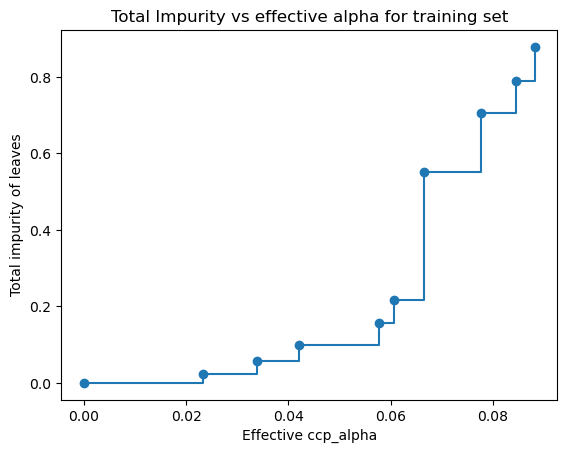

In [28]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Effective ccp_alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

Thay đổi siêu tham số `ccp_alpha` để tìm ra mô hình tốt nhất.

In [29]:
%%time
train_accs = []
test_accs = []
best_test_acc = 0
best_ccp_alpha = None
for ca in ccp_alphas:
    dtcPipeline.set_params(DecisionTree__ccp_alpha = ca)
    dtcPipeline.fit(train_X_df, train_Y_sr)        
    train_accs.append(dtcPipeline.score(train_X_df, train_Y_sr))
    test_accs.append(dtcPipeline.score(val_X_df, val_Y_sr))
    if test_accs[-1] > best_test_acc:
        best_test_acc = test_accs[-1]
        best_ccp_alpha = ca

CPU times: total: 4min 49s
Wall time: 4min 49s


Trực quan hóa kết quả **Accuracy** của các mô hình trên tập **train** và **test** khi thay đổi siêu tham số `ccp_alpha`.

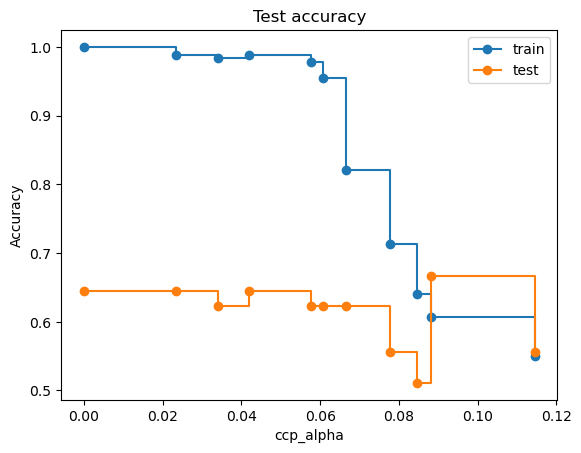

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Test accuracy")
ax.plot(ccp_alphas, train_accs, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_accs, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [31]:
print(f'Best test accuracy = {best_test_acc} with ccp_alpha = {best_ccp_alpha} ')

Best test accuracy = 0.6666666666666666 with ccp_alpha = 0.08823240491861994 


Gán lại `ccp_alpha` và `fit` mô hình trên toàn bộ dữ liệu. Như vậy ta đã có được mô hình cuối cùng.

In [32]:
dtcPipeline.set_params(DecisionTree__ccp_alpha = best_ccp_alpha)
dtcPipeline.fit(X_df,Y_sr)

Pipeline(steps=[('extractfeatures', PreprocessAndFeaturesExtract()),
                ('DecisionTree',
                 DecisionTreeClassifier(ccp_alpha=0.08823240491861994,
                                        criterion='entropy'))])

# Xây dựng mô hình máy học: Multinomial Naive Bayes

### Xây dựng pipeline gồm 2 bước:

* Tiền xử lý văn bản và trích xuất dữ liệu (dùng class **PreprocessAndFeaturesExtract** đã xây dựng ở trên)

* Mô hình Multinomial Naive Bayes (sử dụng **MultinomialNB** có sẵn trong **sklearn.naive_bayes**)

In [33]:
mnb_pipeline = Pipeline(steps = [('preprocessextract',PreprocessAndFeaturesExtract()),('mnb',MultinomialNB())])

### Train mô hình

In [34]:
mnb_pipeline.fit(train_X_df, train_Y_sr)

Pipeline(steps=[('preprocessextract', PreprocessAndFeaturesExtract()),
                ('mnb', MultinomialNB())])

### Kiểm tra độ chính xác của mô hình

* Accuracy score trên tập test

In [35]:
mnb_pipeline.score(train_X_df, train_Y_sr)

0.9831460674157303

* Accuracy score trên tập validation

In [36]:
mnb_pipeline.score(val_X_df, val_Y_sr)

0.8444444444444444

* Như vậy mô hình xây dựng có kết quả đánh giá khá tốt.

# Lưu model

Các mô hình máy học được lưu lại để sử dụng cho việc deploy mô hình lên web.

### Mô hình MLPClassifier

In [37]:
out = open("models/mlpclassifier.pkl",mode = "wb")
dill.dump(pipeline_mlp,out)
out.close()

### Mô hình Cây quyết định

In [38]:
out = open("models/decisiontree.pkl",mode = "wb")
dill.dump(dtcPipeline,out)
out.close()

### Mô hình Multinomial Naive Bayes

In [39]:
out = open("models/multinomialnb.pkl",mode = "wb")
dill.dump(dtcPipeline,out)
out.close()